In [1]:
import torch
import numpy as np
from torchvision import transforms, models
import torch.nn.functional as F
from torchvision.ops import nms
import cv2
import subprocess
import tempfile
import time
import json
import shutil

In [2]:
import sys
import os
project_root= os.getcwd() + "/../"
src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_2_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, filter_valid_bboxes, calculate_iou, assign_targets_to_anchors, sample_minibatch, create_bbox_deltas, apply_deltas_to_boxes, clamp_boxes_to_img_boundary, filter_proposals

from utils import draw_image_with_box, visualize_anchors_and_gt, decode_predictions, decode_deltas, smooth_l1_loss, bbox_transform
from models import RPN, RoIHead

In [3]:
vgg16= models.vgg16(pretrained= True)
backbone= vgg16.features[:-1]
for p in backbone.parameters():
    p.requires_grad= False
rpn_model= RPN()
rpn_model.load_state_dict(torch.load(artifacts_dir + "rpn_5epchs_vgg16bb_s2_r1_lr1e-4_wghts_bs16.pth"))
for p in rpn_model.parameters():
    p.requires_grad= False
roi_head= RoIHead(in_channels= 512, num_classes= 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/vscode/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:31<00:00, 17.6MB/s] 


In [4]:
roi_head.load_state_dict(torch.load(artifacts_dir + "roi_10eps_rpns2r1_2048fc_512p_07fg_015val_wghts.pth"))
for p in roi_head.parameters():
    p.requires_grad= False

In [5]:
@torch.no_grad()
def roi_head_inference(features, proposals, image_shape, roi_head, score_thresh= 0.5, nms_thresh= 0.1):
    roi_out= roi_head(features, [proposals], [image_shape], gt_boxes= None)
    cls_logits= roi_out['cls_logits']
    bbox_deltas= roi_out['bbox_deltas']

    print("cls_logits range:", cls_logits.min().item(), cls_logits.max().item())
    scores= F.softmax(cls_logits, dim= 1)[:, 1]
    print(scores.max())
    pred_boxes= apply_deltas_to_boxes(proposals, bbox_deltas)
    pred_boxes= clamp_boxes_to_img_boundary(pred_boxes, image_shape)

    keep= scores > score_thresh
    pred_boxes= pred_boxes[keep]
    scores= scores[keep]

    keep= nms(pred_boxes, scores, nms_thresh)
    return pred_boxes[keep], scores[keep]


In [6]:
def roi_collate(batch):
    return batch
transforms= transforms.Compose([
    transforms.Resize((512,512)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_test_images= [
    img for img in os.listdir(images_val_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
test_dataset= FaceDataset(image_dir= images_val_dir, label_dir= labels_2_dir, image_list= all_test_images, transform= transforms)

In [7]:
@torch.no_grad()
def generate_proposals(images, image_shapes):
    features= backbone(images)
    with torch.cuda.amp.autocast():
      rpn_out= rpn_model(feat= features, image_shapes= image_shapes, gt_boxes= None)
    proposals= [p[:512] for p in rpn_out['proposals']]
    return proposals, features

cls_logits range: -2.6361403465270996 2.246473789215088
tensor(0.9711)


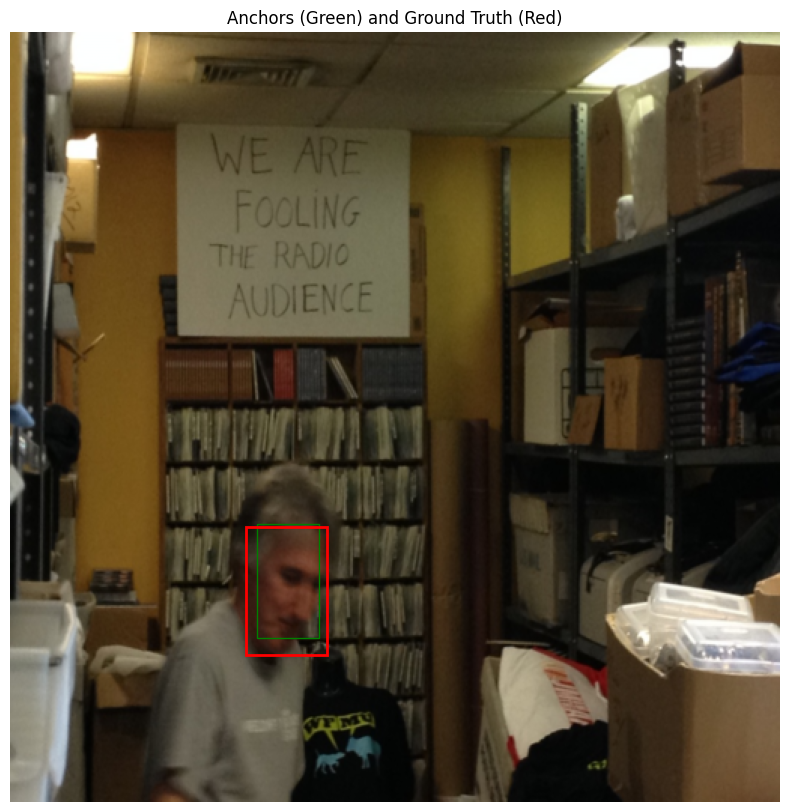

In [8]:
sample_image= test_dataset[1000]['image'].unsqueeze(0)
sample_label= test_dataset[1000]['boxes']

B, _, H, W= sample_image.shape
image_shapes= [(H, W)]

proposals, features= generate_proposals(sample_image, image_shapes)
proposals= proposals[0]
features= features

pred_boxes, pred_scores= roi_head_inference(features, proposals, (H, W), roi_head)
gt_boxes= filter_valid_bboxes(sample_label)
visualize_anchors_and_gt(sample_image.squeeze(0), pred_boxes.cpu(), sample_label)

In [9]:
# def process_frame(frame, backbone, rpn_model,
#                   roi_head, device, score_thresh= 0.5, nms_thresh= 0.1):
#     orig_h, orig_w= frame.shape[:2]
#     frame_rgb= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     transform= transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((512, 512)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
#     ])

#     trasnformed_frame= transform(frame_rgb)

#     input_tensor= trasnformed_frame.unsqueeze(0).to(device)

#     _, _, H, W= input_tensor.shape
#     image_shapes= [(H, W)]

#     proposals, features= generate_proposals(input_tensor, image_shapes, backbone, rpn_model)
#     proposals= proposals[0]

#     pred_boxes, pred_scores= roi_head_inference(
#         features, proposals, (H, W), roi_head, score_thresh= score_thresh, nms_thresh= nms_thresh
#     )

#     scale_x= orig_w / W
#     scale_y= orig_h / H

#     pred_boxes[:, 0]*= scale_x
#     pred_boxes[:, 1]*= scale_y
#     pred_boxes[:, 2]*= scale_x
#     pred_boxes[:, 3]*= scale_y

#     return pred_boxes, pred_scores
# def get_video_info(video_path):
#     cmd= [
#         "ffprobe",
#         "-v", "quiet",
#         "-print_format", "json",
#         "-show_format",
#         "-show_streams",
#         video_path
#     ]
#     try:
#         result= subprocess.run(cmd, check= True, stdout= subprocess.PIPE, stderr= subprocess.PIPE)
#         info= json.loads(result.stdout)
#         video_stream= next((stream for stream in info['streams'] if stream['codec_type'] == 'video'), None)
#         if video_stream:
#             fps= eval(video_stream['r_framerate'])

#             width= video_stream['width']
#             height= video_stream['height']
#             return fps, width, height
#         return None, None, None
#     except (subprocess.CalledProcessError, json.JSONDecodeError, KeyError, StopIteration) as e:
#         print(f"Error gettinv video info: {e}")
#         return None, None, None

# def process_video(
#         video_path, backbone, rpn_model, 
#         roi_head, device, output_path= None,
#         score_thresh= 0.5, nms_thresh= 0.5, sample_every= 1):
    
#     temp_dir= tempfile.mkdtemp()
#     frames_dir= os.path.join(temp_dir, "frames")
#     os.makedirs(frames_dir, exist_ok= True)

#     try:
#         fps, width, height= get_video_info(video_path)
#         if fps is None:
#             print("Couldn't get video info, using defaults")
#             fps= 30
#         print(f"Video info: FPS={fps}, Width={width}, Height={height}")

#         ffmpeg_cmd= [
#             "ffmpeg",
#             "-i", video_path,
#             "-f", "image2pipe",
#             "-pix_fmt", "bgr24",
#             "-vcodec", "rawvideo",
#             "-"
#         ]

#         ffmpeg_process= subprocess.Popen(ffmpeg_cmd, stdout=subprocess.PIPE, stderr= subprocess.PIPE)

    
#         backbone.eval()
#         rpn_model.eval()
#         roi_head.eval()

#         frame_count= 0
#         processed_count= 0
#         frame_size= width * height * 3
#         start_time= time.time()
#         last_time= start_time
#         print("processing video ... press 'q' to quit")

#         while True:
            
#             raw_frame= ffmpeg_process.stdout.read(frame_size)

#             if len(raw_frame) != frame_size:
#                 break

#             frame= np.frombuffer(raw_frame, dtype= np.uint8).reshape((height, width, 3))

#             if frame_count % sample_every == 0:
#                 boxes, scores= process_frame(
#                     frame, backbone, rpn_model,
#                     roi_head, device, score_thresh,
#                     nms_thresh
#                     )
#                 for box, score in zip(boxes, scores):
#                     x1, y1, x2, y2= box.int().tolist()
#                     cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

#                     cv2.putText(frame, f"{score:.2f}", (x1, y1 - 10),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
#                 current_time= time.time()
#                 elapsed= current_time - last_time
#                 if elapsed > 0:
#                     fps_display= 1.0 / elapsed
#                     cv2.putText(frame, f"FPS: {fps_display:.1f}", (10, 30),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
#                 last_time= current_time

#                 cv2.imshow('Object Detection', frame)

#                 if cv2.waitKey(1) & 0xFF == ord('q'):
#                     break
#                 processed_count+= 1

#                 if processed_count % 10 == 0:
#                     elapsed_total= current_time - start_time
#                     avg_fps= processed_count / elapsed_total if elapsed_total > 0 else 0

#                     print(f"Processed {processed_count} frames, Average FPS: {avg_fps:.1f}")
            
#         frame_count+= 1

#         total_time= time.time() - start_time
#         avg_fps= processed_count / total_time if total_time > 0 else 0
#         print(f"Processing complete. Processed {processed_count} frames in {total_time:.1f} seconds")
#         print(f"Average FPS: {avg_fps:.1f}")
    
#     finally:
#         ffmpeg_process.terminate()
#         cv2.destroyAllWindows()
#         shutil.rmtree(temp_dir)
       
            

 

In [10]:
def process_frame(frame, backbone, rpn_model,
                  roi_head, device, score_thresh=0.5, nms_thresh=0.1):
    orig_h, orig_w = frame.shape[:2]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformed_frame = transform(frame_rgb) # <--- Corrected typo: trasnformed_frame -> transformed_frame

    input_tensor = transformed_frame.unsqueeze(0).to(device)

    _, _, H, W = input_tensor.shape
    image_shapes = [(H, W)]

    proposals, features = generate_proposals(input_tensor, image_shapes, backbone, rpn_model)
    proposals = proposals[0]

    pred_boxes, pred_scores = roi_head_inference(
        features, proposals, (H, W), roi_head, score_thresh=score_thresh, nms_thresh=nms_thresh
    )

    scale_x = orig_w / W
    scale_y = orig_h / H

    pred_boxes[:, 0] *= scale_x
    pred_boxes[:, 1] *= scale_y
    pred_boxes[:, 2] *= scale_x
    pred_boxes[:, 3] *= scale_y

    return pred_boxes, pred_scores

def get_video_info(video_path):
    cmd = [
        "ffprobe",
        "-v", "quiet",
        "-print_format", "json",
        "-show_format",
        "-show_streams",
        video_path
    ]
    try:
        # Corrected: removed extra () after subprocess.run
        result = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        info = json.loads(result.stdout)
        video_stream = next((stream for stream in info['streams'] if stream['codec_type'] == 'video'), None)
        if video_stream:
            # Safely get fps, handling cases where it might be a string like "30/1"
            try:
                fps = float(eval(video_stream.get('r_frame_rate', '30/1')))
            except (SyntaxError, NameError):
                fps = 30.0 # Default if evaluation fails

            width = video_stream['width']
            height = video_stream['height']
            return fps, width, height
        return None, None, None
    except (subprocess.CalledProcessError, json.JSONDecodeError, KeyError, StopIteration) as e:
        # Corrected typo: gettinv -> getting
        print(f"Error getting video info: {e}") 
        return None, None, None

def process_video(
        video_path, backbone, rpn_model, 
        roi_head, device, output_path=None, # output_path is not used for real-time display, consider removing or making explicit
        score_thresh=0.5, nms_thresh=0.5, sample_every=1):
    
    # Create temporary directory for frames (still useful for general cleanup, even if not saving frames)
    temp_dir = tempfile.mkdtemp()
    
    ffmpeg_process = None # Initialize to None for the finally block
    
    try:
        fps, width, height = get_video_info(video_path)
        if fps is None:
            print("Couldn't get video info, using defaults")
            fps = 30.0 # Ensure float for calculations
            # If width/height are also None, default them for robust operation
            # You might need to set a sensible default or raise an error
            # For demonstration, let's assume get_video_info returns valid width/height
            # If not, you might need to infer or hardcode a typical video size.
            # For this example, assuming they are set by get_video_info or handle this case.
            if width is None or height is None:
                raise ValueError("Could not get video dimensions from ffprobe. Please ensure ffprobe is installed and video is valid.")


        print(f"Video info: FPS={fps}, Width={width}, Height={height}")

        ffmpeg_cmd = [
            "ffmpeg",
            "-i", video_path,
            "-f", "image2pipe",
            "-pix_fmt", "bgr24",
            "-vcodec", "rawvideo",
            "-"
        ]

        # Use bufsize=10**8 for larger buffer, helps with performance
        ffmpeg_process = subprocess.Popen(ffmpeg_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=10**8)
    
        backbone.eval()
        rpn_model.eval()
        roi_head.eval()

        frame_count = 0        # Total frames read from pipe
        processed_count = 0    # Total frames processed and displayed
        
        frame_size = width * height * 3 # Bytes per frame (BGR)
        
        start_time = time.time()
        last_display_time = time.time() # For instantaneous FPS
        print("Processing video ... press 'q' to quit")

        while True:
            # Read raw frame data from ffmpeg
            raw_frame_data = ffmpeg_process.stdout.read(frame_size)
            
            if len(raw_frame_data) != frame_size:
                # This could be end of stream or an error
                if ffmpeg_process.poll() is not None and len(raw_frame_data) == 0:
                    print("FFmpeg process finished, end of video stream.")
                elif len(raw_frame_data) > 0:
                    print(f"Warning: Partial frame read. Expected {frame_size} bytes, got {len(raw_frame_data)}.")
                else:
                    print("No more data from ffmpeg stdout, breaking loop.")
                break

            frame = np.frombuffer(raw_frame_data, dtype=np.uint8).reshape((height, width, 3))

            if frame_count % sample_every == 0:
                boxes, scores = process_frame(
                    frame, backbone, rpn_model,
                    roi_head, device, score_thresh,
                    nms_thresh
                )
                
                for box, score in zip(boxes, scores):
                    x1, y1, x2, y2 = box.int().tolist()
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Corrected: y-coordinate offset for text
                    cv2.putText(frame, f"{score:.2f}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                current_time = time.time()
                
                # Calculate and display instantaneous FPS
                elapsed_display = current_time - last_display_time
                if elapsed_display > 0:
                    fps_display = 1.0 / elapsed_display
                    cv2.putText(frame, f"FPS: {fps_display:.1f}", (10, 30), # Top-left corner
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                last_display_time = current_time

                cv2.imshow('Object Detection', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    print("'q' pressed, quitting.")
                    break
                
                processed_count += 1

                # Print average FPS periodically for console output
                if processed_count % 10 == 0:
                    elapsed_total = current_time - start_time
                    avg_fps_total = processed_count / elapsed_total if elapsed_total > 0 else 0
                    print(f"Processed {processed_count} frames, Average FPS: {avg_fps_total:.1f}")
            
            frame_count += 1 # Increment total frame count regardless of sampling

        # Final statistics after loop ends
        total_time = time.time() - start_time
        avg_fps = processed_count / total_time if total_time > 0 else 0
        print(f"Processing complete. Processed {processed_count} frames (out of {frame_count} total read) in {total_time:.1f} seconds")
        print(f"Overall Average FPS: {avg_fps:.1f}")
    
    finally:
        if ffmpeg_process and ffmpeg_process.poll() is None:
            ffmpeg_process.terminate()
            ffmpeg_process.wait(timeout=5) # Give it a moment to terminate
            if ffmpeg_process.poll() is None:
                ffmpeg_process.kill() # Force kill if still not terminated
        cv2.destroyAllWindows()
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

In [11]:
vids_dir= project_root + "test_vids/"

In [12]:
vids_dir= project_root + "test_vids/"
device= torch.device('cpu')
backbone= backbone.to(device)
rpn_model= rpn_model.to(device)
roi_head= roi_head.to(device)
process_video(
    video_path= vids_dir+ "test.mp4",
    backbone= backbone,
    rpn_model= rpn_model,
    roi_head= roi_head,
    device= device,
    score_thresh= 0.5,
    nms_thresh= 0.1,
    sample_every= 1
)

error: OpenCV(4.7.0) /opencv-4.7.0/modules/highgui/src/window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
